In [148]:
%load_ext autoreload

import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np

import functools
import time

from quil_utils import *
from pyquil.quil import Pragma, Program
from pyquil.api import get_qc,QVM
from pyquil.gates import *
from quil_utils import Compiled_Circuit
from utils import DeviceUtils,DeviceScanner,BraketTaskScanner


import json
import pandas as pd
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
@circuit.subroutine(register=True)
def H_line (n_qubits,line_length):
    """
    Creates a circuit with n_qubits, each with line_length hadamards applied
    
    Parameters:
    ----------------
    n_qubits : int #of qubits
    line_length : int # of Hadamards to apply to each qubit
    """
    circ = Circuit()
    for _ in range(line_length):
        circ.h(range(n_qubits))
    return circ

In [3]:
@circuit.subroutine(register=True)
def GHZ (n_qubits):
    """
    Creates a GHZ circuit with n_qubits
    
    Parameters:
    ----------------
    n_qubits : int #of qubits
    """
    out = Circuit().h([0])
    for i in range(n_qubits-1):
        out.cnot(0,i+1)

    return out
        

In [4]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
# rigetti = LocalSimulator()
# ion_q = LocalSimulator()

#############################
Device name:  Aspen-M-2
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2
Device provider: Rigetti
Device status: ONLINE
Device availability:  False
Device region:  us-west-1
Supported gates:  ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z', 'start_verbatim_box', 'end_verbatim_box']
a:b:c:us-west-1


{'task': 0.3, 'shot': 0.00035}

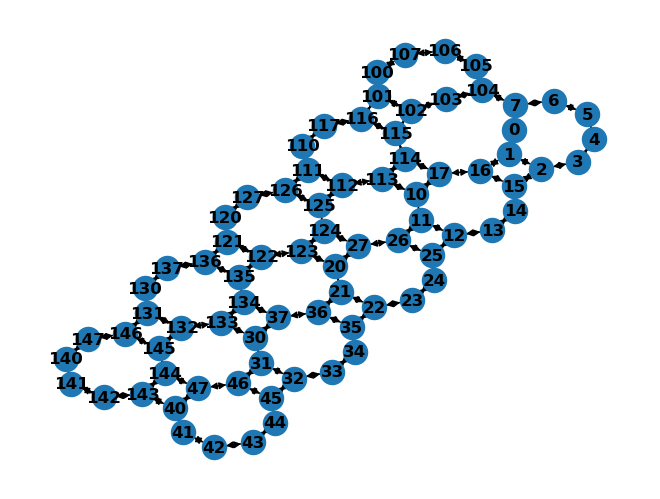

In [5]:
DeviceScanner(device=rigetti).list_properties()
DeviceScanner(device=rigetti).get_cost_infos()

#############################
Device name:  IonQ Device
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:::device/qpu/ionq/ionQdevice
Device provider: IonQ
Device status: ONLINE
Device availability:  False
Device region:  
Supported gates:  ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap']
a:b:c:us-east-1


{'task': 0.3, 'shot': 0.01}

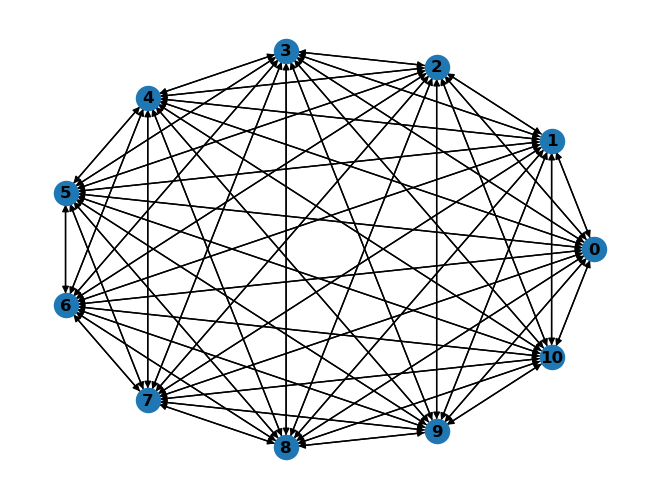

In [6]:
DeviceScanner(device=ion_q).list_properties()
DeviceScanner(device=ion_q).get_cost_infos()

## Line_Hadamard
We apply a set of hadamards to 10 qubits, trying to benchmark them

In [7]:
shots = 100
#set_n_qubits = range(3,10)
n_qubits = 10
set_line_length = np.geomspace(5,100,num=5,dtype=int)
rigetti_tasks = []
ionq_tasks = []
print(set_line_length)

[  5  10  22  47 100]


In [8]:
id_dict = {}

for line_length in set_line_length:
    id_dict[str(line_length)] = {}
    
    circ = H_line(n_qubits,line_length)
    
    rigetti_task = rigetti.run(circ,shots=shots)
    ionq_task = ion_q.run(circ,shots=shots)
    rigetti_tasks.append(rigetti_task)
    ionq_tasks.append(ionq_task)
    
    id_dict[str(line_length)] = {'rigetti' : {'id' : rigetti_task.id},'ionq' : {'id' : ionq_task.id}}

In [9]:
with open('H_line.json','w') as f:
    json.dump(id_dict,f,indent=3)

In [10]:
rigetti_ids = [task.id for task in rigetti_tasks]
ionq_ids = [task.id for task in ionq_tasks]


In [11]:
rigetti_task_scanners = [BraketTaskScanner(qtask=task) for task in rigetti_tasks]
ion_q_task_scanners = [BraketTaskScanner(qtask=task) for task in ionq_tasks]

In [16]:
status_rigetti = [task.get_status() for task in rigetti_task_scanners]
status_ionq = [task.get_status() for task in ion_q_task_scanners]
print(status_rigetti,status_ionq)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED'] ['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [189]:
results_rigetti = [qtask.get_results() for qtask in rigetti_task_scanners]
results_ion_q = [qtask.get_results()for qtask in ion_q_task_scanners]

In [19]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

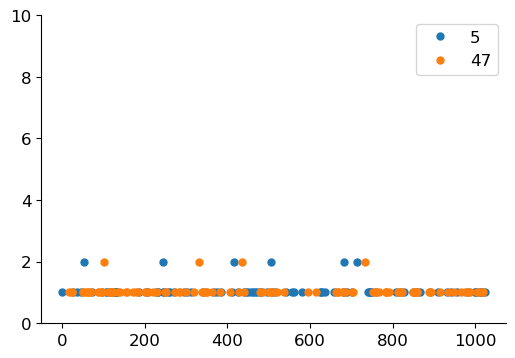

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for idx,results in enumerate(results_rigetti):
    if set_line_length[idx]%2:
        counts = results.measurement_counts
        ax.plot([int(x,2) for x in counts.keys()],
                [x for x in counts.values()],
                #color="orange",
                marker = 'o',
                ms=5,
                linestyle='',
                label=str(set_line_length[idx]))
ax.set_ylim(0,10)
ax.legend()

# RIGETTI

In [187]:

H_line_measures = {}
for i,H_len in enumerate(set_line_length):
    results = results_rigetti[i]
#     measure[str(H_len)] = {}
#     meas = measure[str(H_len)]
    H_line_measures[str(H_len)] = []
    measure = H_line_measures[str(H_len)]
    for qubit_number in range(n_qubits):
        #meas[str(qubit_number)] = {'0':0,'1':0}
        ones = results.measurements[:,qubit_number].sum()
        zeros = shots - ones
#         meas = [{'H_len' : H_len,
#                 'qubit_n' : qubit_number,
#                'value': '0',
#                 'counts' : zeros},
#                {'H_len' : H_len,
#                 'qubit_n' : qubit_number,
#                'value': '1','counts':ones}]
        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '0',
                'counts' : zeros})
        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '1','counts':ones})
#         meas[str(qubit_number)]['1'] = ones
#         meas[str(qubit_number)]['0'] = zeros



AxesSubplot(0.125,0.747241;0.775x0.132759)
AxesSubplot(0.125,0.587931;0.775x0.132759)
AxesSubplot(0.125,0.428621;0.775x0.132759)
AxesSubplot(0.125,0.26931;0.775x0.132759)
AxesSubplot(0.125,0.11;0.775x0.132759)


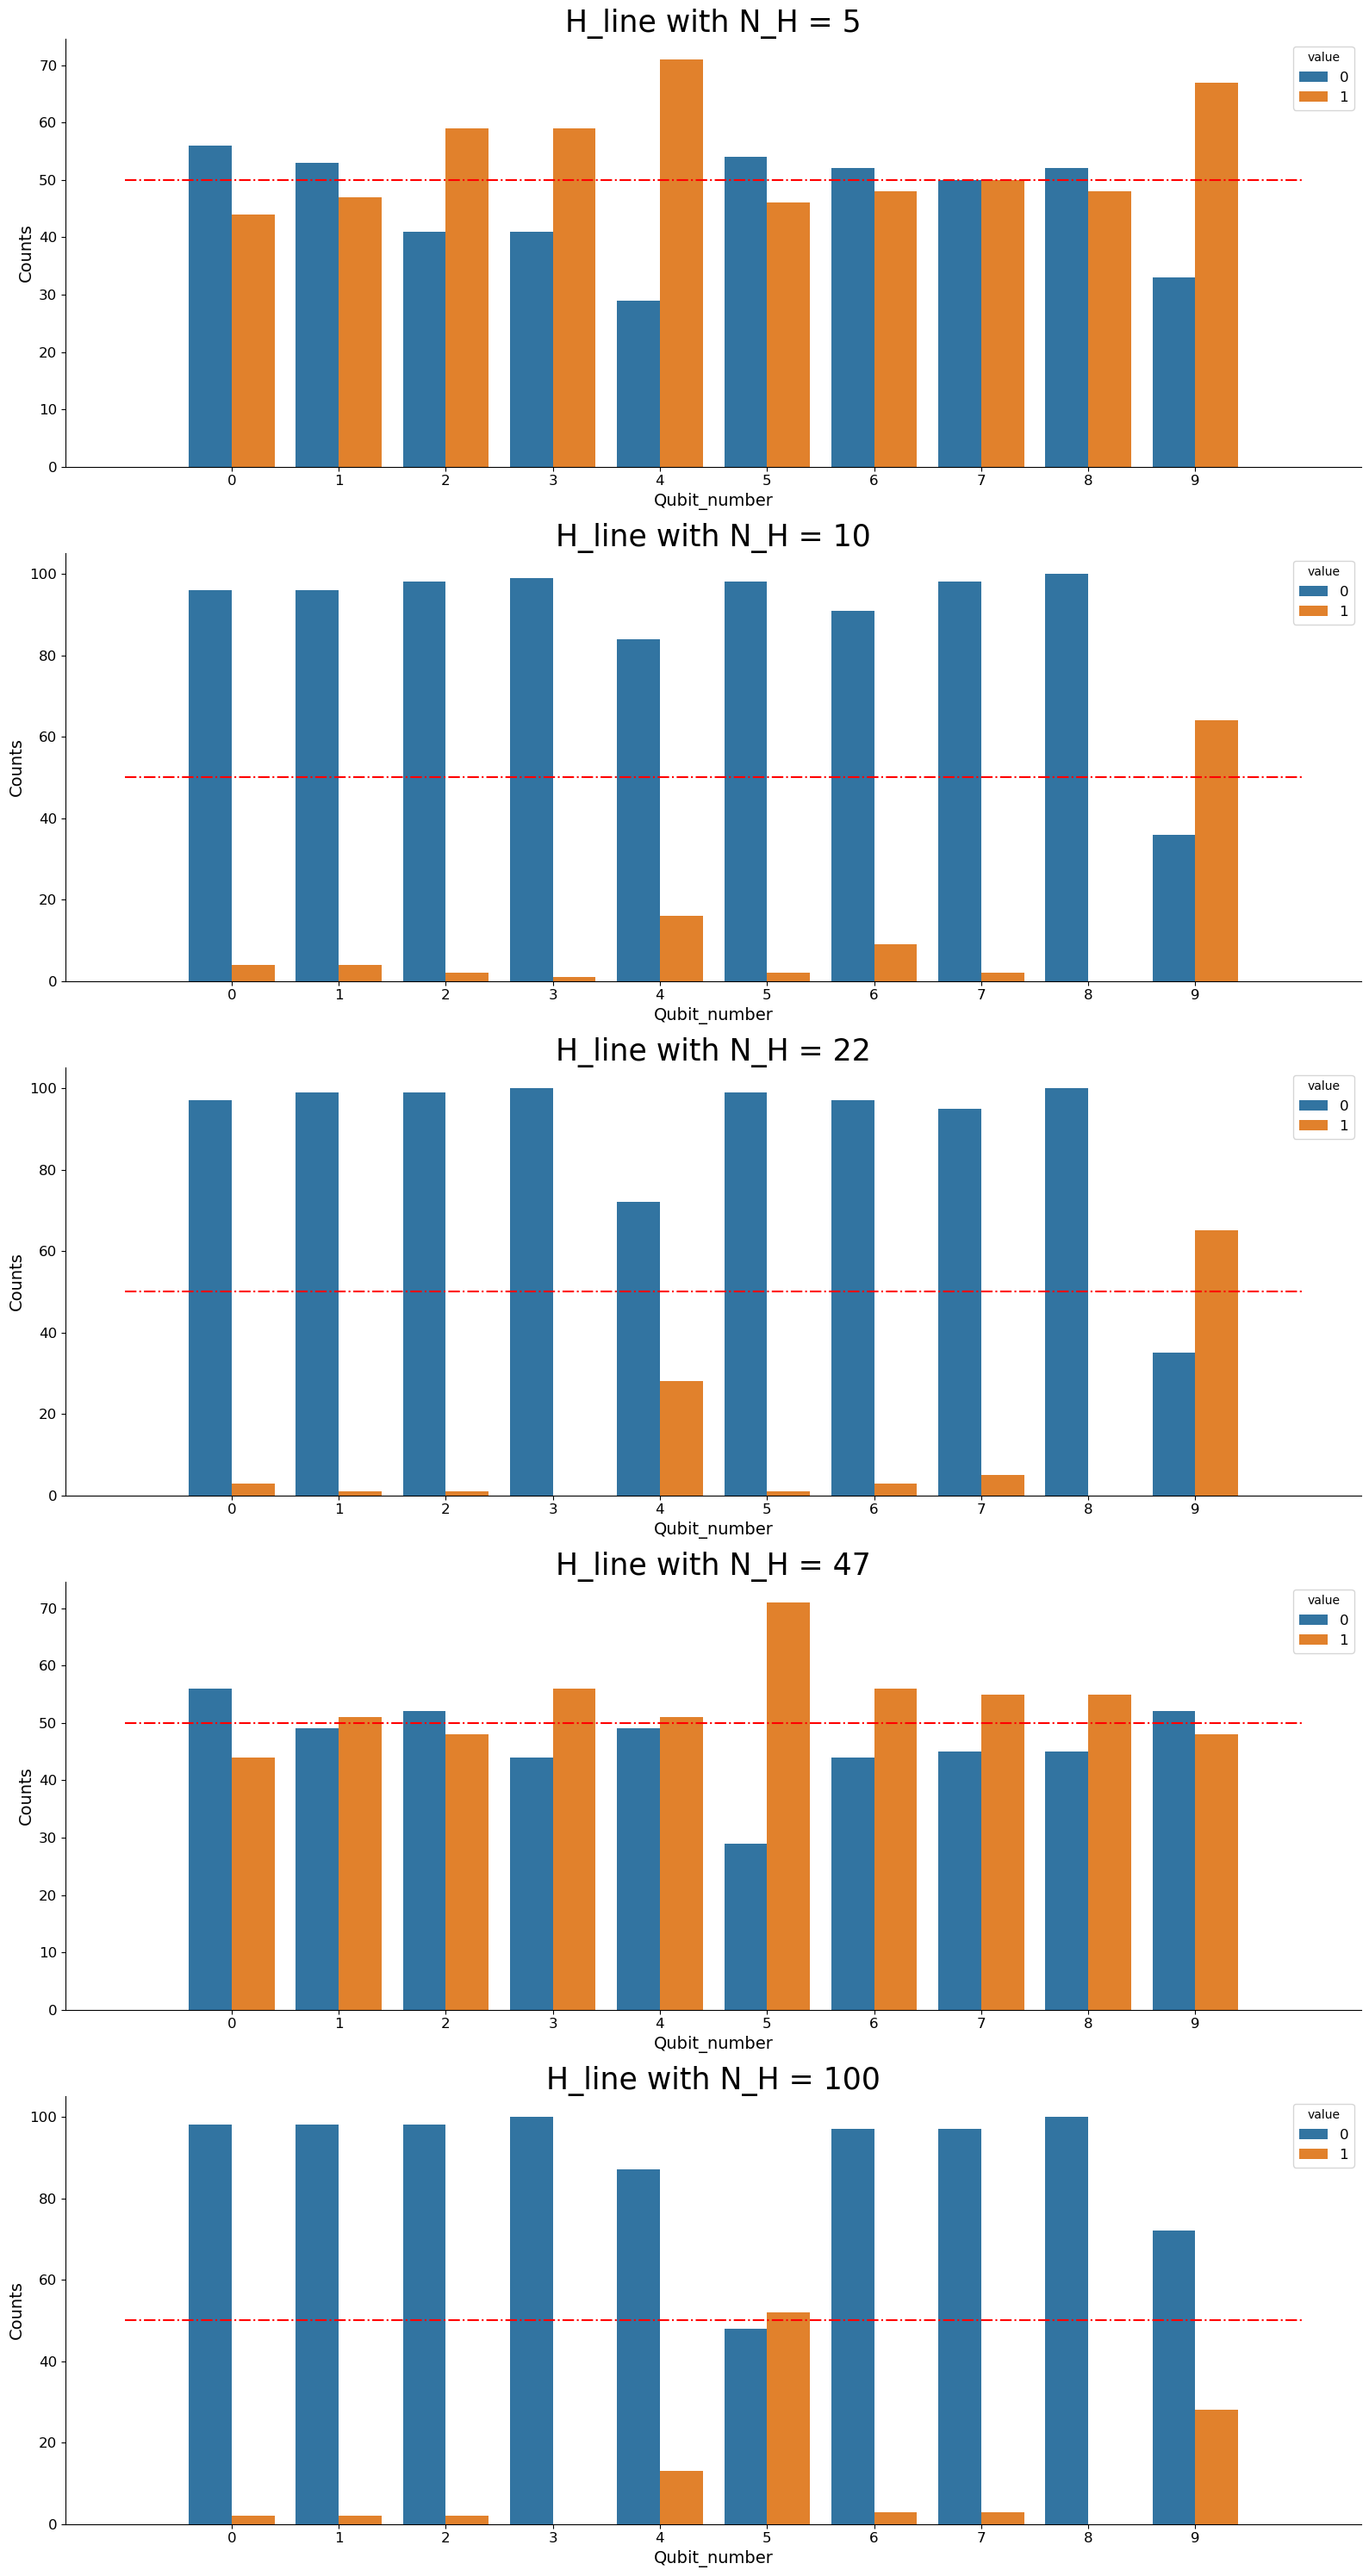

In [188]:
fig, axx = plt.subplots(5, 1, figsize=(16, 30),tight_layout=True,)
axx = axx.reshape(-1)
i=0
for key in H_line_measures:
    measure = H_line_measures[key]
    df = pd.DataFrame(measure)
    #print(df)
    ax = axx[i]
    i+=1
    print(ax)
    sns.barplot(x="qubit_n", y="counts",hue="value", data=df,ax=ax)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Qubit_number")
    ax.set_title(f"H_line with N_H = {key}",size=25)
    ax.hlines(50,-1,10,linestyles='-.',color='red')

# IonQ

In [190]:

H_line_measures = {}
for i,H_len in enumerate(set_line_length):
    results = results_ion_q[i]
#     measure[str(H_len)] = {}
#     meas = measure[str(H_len)]
    H_line_measures[str(H_len)] = []
    measure = H_line_measures[str(H_len)]
    for qubit_number in range(n_qubits):
        #meas[str(qubit_number)] = {'0':0,'1':0}
        ones = results.measurements[:,qubit_number].sum()
        zeros = shots - ones
#         meas = [{'H_len' : H_len,
#                 'qubit_n' : qubit_number,
#                'value': '0',
#                 'counts' : zeros},
#                {'H_len' : H_len,
#                 'qubit_n' : qubit_number,
#                'value': '1','counts':ones}]
        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '0',
                'counts' : zeros})
        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '1','counts':ones})
#         meas[str(qubit_number)]['1'] = ones
#         meas[str(qubit_number)]['0'] = zeros



AxesSubplot(0.125,0.747241;0.775x0.132759)
AxesSubplot(0.125,0.587931;0.775x0.132759)
AxesSubplot(0.125,0.428621;0.775x0.132759)
AxesSubplot(0.125,0.26931;0.775x0.132759)
AxesSubplot(0.125,0.11;0.775x0.132759)


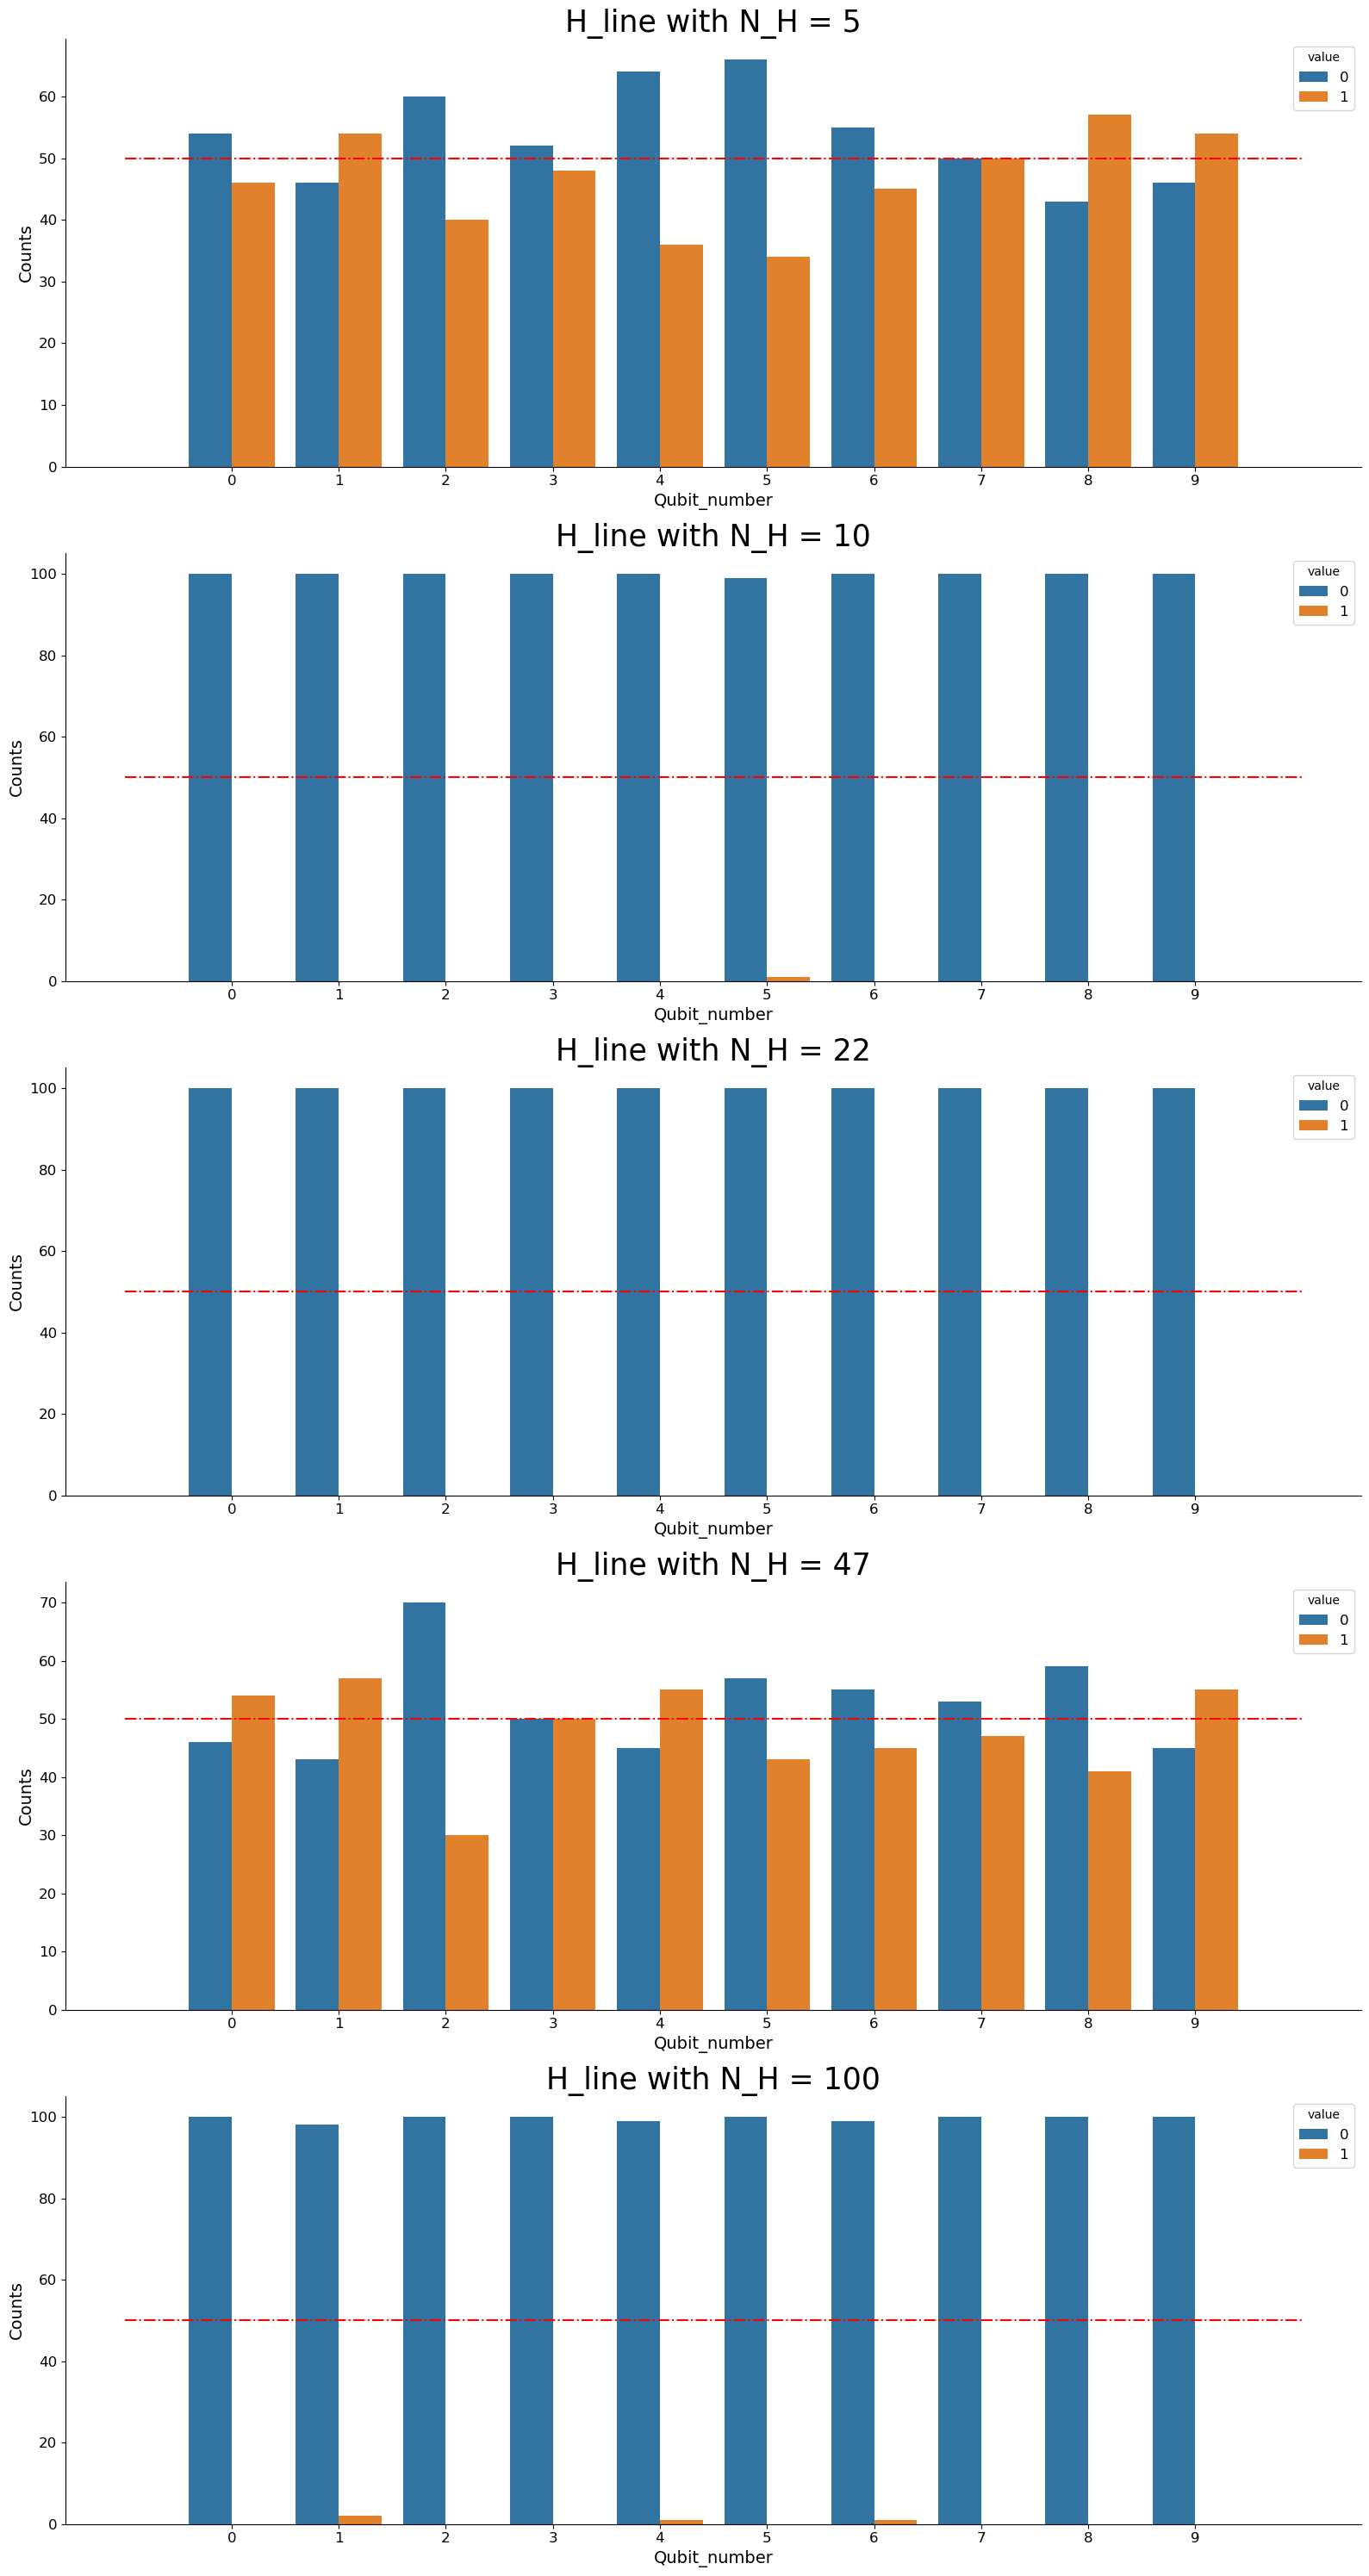

In [191]:
fig, axx = plt.subplots(5, 1, figsize=(16, 30),tight_layout=True,)
axx = axx.reshape(-1)
i=0
for key in H_line_measures:
    measure = H_line_measures[key]
    df = pd.DataFrame(measure)
    #print(df)
    ax = axx[i]
    i+=1
    print(ax)
    sns.barplot(x="qubit_n", y="counts",hue="value", data=df,ax=ax)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Qubit_number")
    ax.set_title(f"H_line with N_H = {key}",size=25)
    ax.hlines(50,-1,10,linestyles='-.',color='red')

# Qft Benchmarking
Plotting QFT results

In [ ]:
aspen_10 = "arn:aws:braket:us-west-1:058017682654:quantum-task/00e27411-115c-404c-b586-2a3c5da198ec"
aspen_8 = "arn:aws:braket:us-west-1:058017682654:quantum-task/14cb4635-c75d-463d-a4e4-c3d74a4e0686"
aspen_6 = "arn:aws:braket:us-west-1:058017682654:quantum-task/3fcb3e03-5eea-407e-89d6-354faf00b160"
aspen_5 = "arn:aws:braket:us-west-1:058017682654:quantum-task/0ea84501-f757-470a-ba40-875bf3b7ee87"
aspen_4 = "arn:aws:braket:us-west-1:058017682654:quantum-task/034cb3e9-0628-440d-a13b-69b453254abd"
aspen_3 = "arn:aws:braket:us-west-1:058017682654:quantum-task/a0f298f3-b2dd-448d-9223-bf1e22305a6a"

tasks_arn = [aspen_3,aspen_4,aspen_5,aspen_6,aspen_8,aspen_10]

In [ ]:
task_scanner = [BraketTaskScanner(task_arn=qtask_arn) for qtask_arn in tasks_arn]

In [ ]:
results_rigetti = [qtask.get_results() for qtask in task_scanner]

In [ ]:
results_rigetti[0].measurement_probabilities